In [364]:
import sqlalchemy
import pandas as pd
import numpy as np

import mplfinance as mpf
import utils.ta_lib_indicators as ti

import ipywidgets as widgets
import talib


In [365]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['Indicators', 'TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info']


In [366]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
stock_ticker = 'TSLA'
daily_df = pd.read_sql_table(
    stock_ticker + '_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table(
    stock_ticker + '_1_Min_Candles', 
    con=engine, 
    index_col='Datetime'
    )

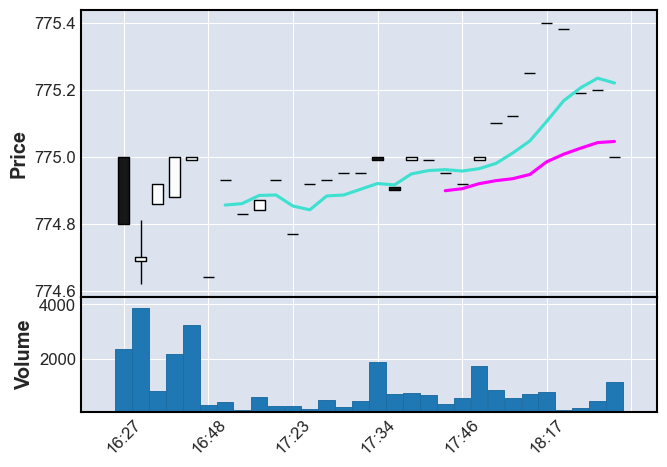

In [367]:
minutely_slice = minutely_df.iloc[-30:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [368]:
pattern_list = []
pattern_df = pd.DataFrame(list(ti.pattern_recognition.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in ti.pattern_recognition.items():
    pattern_list.append(pattern)
print(pattern_list)

['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP', 'CDL

In [369]:
sel_pattern = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        value=['Doji'],
        rows=min(25, len(pattern_list)),
        description='Candle Pattern:',
        grid_layout=''
    )

In [370]:
overlap_list = []
items = ti.overlap_studies.items()
overlap_df = pd.DataFrame(list(items), columns=['Index', 'Overlap'])
overlap_df = overlap_df.set_index('Index')
for i, name in items:
    overlap_list.append(i)
print(overlap_list)

['BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA']


In [371]:
sel_overlap = widgets.SelectMultiple(
        options=overlap_df['Overlap'],
        # value=['Doji'],
        rows=min(25, len(overlap_list)),
        description='Overlap Studies:'
    )

In [372]:
momentum_list = []
items = ti.momentum_indicators.items()
momentum_df = pd.DataFrame(list(items), columns=['Index', 'Momentum'])
momentum_df = momentum_df.set_index('Index')
for i, name in items:
    momentum_list.append(i)
print(momentum_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR']


In [373]:
sel_momentum = widgets.SelectMultiple(
        options=momentum_df['Momentum'],
        # value=['Doji'],
        rows=min(25, len(momentum_list)),
        description='Momentum Indicators:'
    )

In [374]:
volume_list = []
items = ti.volume_indicators.items()
volume_df = pd.DataFrame(list(items), columns=['Index', 'Volume'])
volume_df = volume_df.set_index('Index')
for i, name in items:
    volume_list.append(i)
print(volume_list)

['AD', 'ADOSC', 'OBV']


In [375]:
sel_volume = widgets.SelectMultiple(
        options=volume_df['Volume'],
        # value=['Doji'],
        rows=min(25, len(volume_list)),
        description='Volume Indicators:'
    )

In [376]:
volatility_list = []
items = ti.volatility_indicators.items()
volatility_df = pd.DataFrame(list(items), columns=['Index', 'Volatility'])
volatility_df = volatility_df.set_index('Index')
for i, name in items:
    volatility_list.append(i)
print(volatility_list)

['ATR', 'NATR', 'TRANGE']


In [377]:
sel_volatility = widgets.SelectMultiple(
        options=volatility_df['Volatility'],
        # value=['Doji'],
        rows=min(25, len(volatility_list)),
        description='Volatility Indicators:'
    )

In [378]:
price_transform_list = []
items = ti.price_transform.items()
price_transform_df = pd.DataFrame(list(items), columns=['Index', 'Price Transform'])
price_transform_df = price_transform_df.set_index('Index')
for i, name in items:
    price_transform_list.append(i)
print(price_transform_list)

['AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE']


In [379]:
sel_price_transform = widgets.SelectMultiple(
        options=price_transform_df['Price Transform'],
        # value=['Doji'],
        rows=min(25, len(volume_list)),
        description='Price Transform:'
    )

In [380]:
cycle_list = []
items = ti.cycle_indicators.items()
cycle_df = pd.DataFrame(list(items), columns=['Index', 'Cycle'])
cycle_df = cycle_df.set_index('Index')
for i, name in items:
    cycle_list.append(i)
print(cycle_list)

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE']


In [381]:
sel_cycle = widgets.SelectMultiple(
        options=cycle_df['Cycle'],
        # value=['Doji'],
        rows=min(25, len(cycle_list)),
        description='Cycle Indicators:'
    )

In [382]:
statistic_functions_list = []
items = ti.statistic_functions.items()
statistic_functions_df = pd.DataFrame(list(items), columns=['Index', 'Statistic Functions'])
statistic_functions_df = statistic_functions_df.set_index('Index')
for i, name in items:
    statistic_functions_list.append(i)
print(statistic_functions_list)

['BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


In [383]:
sel_statistic_functions = widgets.SelectMultiple(
        options=statistic_functions_df['Statistic Functions'],
        # value=['Doji'],
        rows=min(25, len(statistic_functions_list)),
        description='Statistic Functions:'
    )

In [384]:
df = minutely_df.copy()

In [385]:
output = widgets.Output()

In [386]:
button_submit = widgets.Button(
    description='Submit',
    disabled=False,
    )

In [387]:
display(
    sel_overlap,
    sel_momentum,
    sel_volume,
    sel_volatility,
    sel_price_transform,
    sel_cycle,
    sel_pattern,
    sel_statistic_functions, 
    button_submit, 
    output,
    )
with output:
    print(list(pattern_df[pattern_df['Pattern'].isin(list(sel_pattern.value))].index))

SelectMultiple(description='Overlap Studies:', options=('Bollinger Bands', 'Double Exponential Moving Average'…

SelectMultiple(description='Momentum Indicators:', options=('Average Directional Movement Index', 'Average Dir…

SelectMultiple(description='Volume Indicators:', options=('Chaikin A/D Line', 'Chaikin A/D Oscillator', 'On Ba…

SelectMultiple(description='Volatility Indicators:', options=('Average True Range', 'Normalized Average True R…

SelectMultiple(description='Price Transform:', options=('Average Price', 'Median Price', 'Typical Price', 'Wei…

SelectMultiple(description='Cycle Indicators:', options=('Hilbert Transform - Dominant Cycle Period', 'Hilbert…

SelectMultiple(description='Candle Pattern:', index=(15,), options=('Two Crows', 'Three Black Crows', 'Three I…

SelectMultiple(description='Statistic Functions:', options=('Beta', "Pearson's Correlation Coefficient (r)", '…

Button(description='Submit', style=ButtonStyle())

Output()

In [421]:

def show_df(b):
    df = minutely_df.copy()
    output.clear_output()
    sel_overlap_list = list(overlap_df[overlap_df['Overlap'].isin(list(sel_overlap.value))].index)
    sel_momentum_list = list(momentum_df[momentum_df['Momentum'].isin(list(sel_momentum.value))].index)
    sel_volume_list = list(volume_df[volume_df['Volume'].isin(list(sel_volume.value))].index)
    sel_volatility_list = list(volatility_df[volatility_df['Volatility'].isin(list(sel_volatility.value))].index)
    sel_price_transform_list = list(price_transform_df[price_transform_df['Price Transform'].isin(list(sel_price_transform.value))].index)
    sel_cycle_list = list(cycle_df[cycle_df['Cycle'].isin(list(sel_cycle.value))].index)
    sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel_pattern.value))].index)
    sel_statistic_functions = list(statistic_functions_df[statistic_functions_df['Cycle'].isin(list(sel_statistic_functions.value))].index)
    print('printing')
    for overlap in sel_overlap_list:
        print(overlap)
        pattern_function = getattr(talib, overlap)
        try:
            result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
            df[overlap] = result
        except Exception as e:
            print(f"{type(e)} Exception! {e}")
    for pattern in sel_pattern_list:
        print(pattern)
        pattern_function = getattr(talib, pattern)
        try:
            result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
            df[pattern] = result
        except Exception as e:
            print(f"{type(e)} Exception! {e}")
    # print(df.head())
    # return df
    with output:
        # print(f"{sel_pattern_list}")
        print(df.head())
    # return sel_pattern_list

button_submit.on_click(show_df)

In [422]:
# df = minutely_df.copy()
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel_pattern.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())


                       Open    High     Low   Close  Volume  CDLDOJI  \
Datetime                                                               
2021-09-02 12:42:00  736.10  736.19  735.72  735.73   10329        0   
2021-09-02 12:43:00  735.72  735.84  735.39  735.51   16975        0   
2021-09-02 12:44:00  735.50  735.50  735.24  735.40   21540        0   
2021-09-02 12:45:00  735.35  735.58  735.17  735.41   32560        0   
2021-09-02 12:46:00  735.39  735.43  734.80  734.83   52841        0   

                     Trailing Stop  Trade Signal  Pct Change  Stop Loss  \
Datetime                                                                  
2021-09-02 12:42:00            NaN           0.0         NaN        0.0   
2021-09-02 12:43:00            NaN           0.0   -0.000299        0.0   
2021-09-02 12:44:00            NaN           0.0   -0.000150        0.0   
2021-09-02 12:45:00            NaN           0.0    0.000014        0.0   
2021-09-02 12:46:00            NaN           

In [423]:
len(sel_pattern_list)
df['Sum Patterns'] = df.iloc[:, -(len(sel_pattern_list)):].sum(axis=1)
# df.drop(columns=sel_pattern_list, inplace=True)


In [424]:
atr_function = getattr(talib, 'ATR')

atr_result = atr_function(df['High'], df['Low'], df['Close'], timeperiod=14)

atr_factor = 2.5

df['Trailing Stop'] = df['Close'] - (atr_result * atr_factor)



In [425]:
df['Trade Signal'] = 0.0

threshold_value = 0.0

def check_sum_value(sum_value):
    if sum_value > threshold_value:
        return 1
    elif sum_value < -threshold_value:
        return -1
    else:
        return 0.0

df['Trade Signal'] = df['Sum Patterns'].apply(lambda x: check_sum_value(x))
df.drop(columns='Sum Patterns', inplace=True)
       

In [426]:
df['Pct Change'] = df['Close'].pct_change()


In [427]:
df['Stop Loss'] = np.where(df['Trade Signal']==1,df['Trailing Stop'],0.0)

In [428]:
print(df.iloc[:, -4:].tail(20))
print(df['Trade Signal'].value_counts())

                     CDLCLOSINGMARUBOZU  CDLCONCEALBABYSWALL  \
Datetime                                                       
2021-10-01 17:23:00                   0                    0   
2021-10-01 17:28:00                   0                    0   
2021-10-01 17:29:00                   0                    0   
2021-10-01 17:31:00                   0                    0   
2021-10-01 17:32:00                   0                    0   
2021-10-01 17:34:00                -100                    0   
2021-10-01 17:35:00                -100                    0   
2021-10-01 17:37:00                 100                    0   
2021-10-01 17:38:00                   0                    0   
2021-10-01 17:42:00                   0                    0   
2021-10-01 17:46:00                   0                    0   
2021-10-01 17:59:00                 100                    0   
2021-10-01 18:00:00                   0                    0   
2021-10-01 18:14:00                   0 

In [429]:
last_stop = 0.0
# df['Recalculated Stop Loss'] = pd.NA
for index, row in df.iterrows():
    if row['Pct Change'] > 0.0 and row['Trailing Stop'] > last_stop:
        df.loc[index,'Stop Loss'] = row['Trailing Stop']
    else:
        df.loc[index,'Stop Loss'] = last_stop

    last_stop = row['Stop Loss']


In [430]:
print(df.iloc[:, -5:].head(20))

                     CDLBREAKAWAY  CDLCLOSINGMARUBOZU  CDLCONCEALBABYSWALL  \
Datetime                                                                     
2021-09-02 12:42:00             0                   0                    0   
2021-09-02 12:43:00             0                   0                    0   
2021-09-02 12:44:00             0                   0                    0   
2021-09-02 12:45:00             0                   0                    0   
2021-09-02 12:46:00             0                   0                    0   
2021-09-02 12:47:00             0                   0                    0   
2021-09-02 12:48:00             0                   0                    0   
2021-09-02 12:49:00             0                   0                    0   
2021-09-02 12:50:00             0                   0                    0   
2021-09-02 12:51:00             0                   0                    0   
2021-09-02 12:52:00             0                   0           

In [431]:
df.dropna().to_sql('Indicators', con=engine, if_exists='replace')